<br><br>
<font size='6'><b> Weakly Supervised Microstructure Segmentation
</b></font><br><br>

<br>
<div class=pull-right>
By Juwon Na<br>
Industrial AI Lab at POSTECH
</div>

## 1. Import Library & Function

In [1]:
# import os
# os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
# os.environ["CUDA_VISIBLE_DEVICES"]="2"

In [2]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from glob import glob
from PIL import Image

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchsummary import summary
from torch.autograd import Variable

use_cuda = torch.cuda.is_available()

In [3]:
def to_gray(img):
    
    # input: RGB image
    # output: gray image
    
    img = Image.fromarray(img)
    gray_img = Image.new("L", img.size)
    gray_img.paste(img)
    gray_img = np.array(gray_img)
    
    return gray_img

In [4]:
def to_red(img):
    
    # input: gray image
    # output: red-colored image
    
    img = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
    img[:,:,1] = 0
    img[:,:,2] = 0
    
    img = img / np.max(img) * 255
    
    return img.astype('uint8')

In [5]:
def change_background(scr):
    
    # input: scribble image with black background
    # output: scribble image with white background
    
    scr = Image.fromarray(scr)
    
    data = []
    for p in scr.getdata():
        if p[0] < 1 and p[1] < 1 and p[2] < 1:
            data.append((255, 255, 255))
        else:
            data.append(p)
    
    scr.putdata(data)
    
    return np.array(scr)

In [6]:
def image_blend(img1, img2, p):
    
    # input: two different images
    # output: an blended image
    
    image1 = Image.fromarray(img1)
    image2 = Image.fromarray(img2)
    
    image1 = image1.convert('RGBA')
    image2 = image2.convert('RGBA')
    
    image = Image.blend(image1, image2, p)
    
    return image

In [7]:
def image_overlay(img1, img2):
    
    # input: two different images
    # output: an overlaid image
    
    image1 = Image.fromarray(img1)
    image2 = Image.fromarray(img2)

    img2 = to_gray(img2)
    mask = np.zeros(img2.shape)
    for i,j in zip(np.where(img2 != 255)[0], np.where(img2 != 255)[1]):
        mask[i,j] = 255
    mask = Image.fromarray(mask.astype('uint8'))
        
    image1.paste(image2, (0, 0), mask)
    
    return image1

In [8]:
def masking(scr):
    
    # input: scribble
    # output: mask and correspondance
    
    scr = scr.reshape(-1, 3)
    color_set = np.unique([i for i in scr], axis = 0)
    corr = []
    
    for i,j in enumerate(color_set):
        scr[np.where(np.all(scr == j, axis = -1))[0]] = i
        corr.append(j)
    
    return scr[:,0], np.array(corr)

In [9]:
def entropy(prob):
    
    # input: prob map
    # output: uncertainty map
    
    return (-prob * torch.log(prob)).sum(dim = 2)

def least_confidence(prob):
    
    # input: prob map
    # output: uncertainty map
    
    return 1.0 - prob.max(dim = 2)[0]

def margin_sampling(prob):
    
    # input: prob map
    # output: uncertainty map
    
    top2 = prob.topk(k = 2, dim = 2).values
    
    return 255 - (top2[:,:,0] - top2[:,:,1]).abs()

In [12]:
class LambdaLR:
    
    # input: current epoch
    # output: weight of learning rate decay
    
    def __init__(self, n_epoch, decay_start_epoch):
        self.n_epoch = n_epoch
        self.decay_start_epoch = decay_start_epoch
        
    def step(self, epoch):
        return 1.0 - max(0, epoch - self.decay_start_epoch) / (self.n_epoch - self.decay_start_epoch)

In [13]:
def make_dir(folder_dir):
    
    # input: directory path
    # output: make a directory
    
    if not(os.path.isdir(folder_dir)):
        os.makedirs(folder_dir)

In [14]:
def save_model(model, folder_dir):
    
    # input: model and path
    # output: save model
    
    make_dir(folder_dir)
    torch.save(model.state_dict(), folder_dir + 'model.pt')
    
def load_model(model, folder_dir):
    
    # input: model and path
    # output: load model
    
    model.load_state_dict(torch.load(folder_dir + 'model.pt'))

In [15]:
def save_img(img, file_dir):
    
    # input: image and path
    # output: save image
    
    img.save(file_dir)

## 2. Load Data

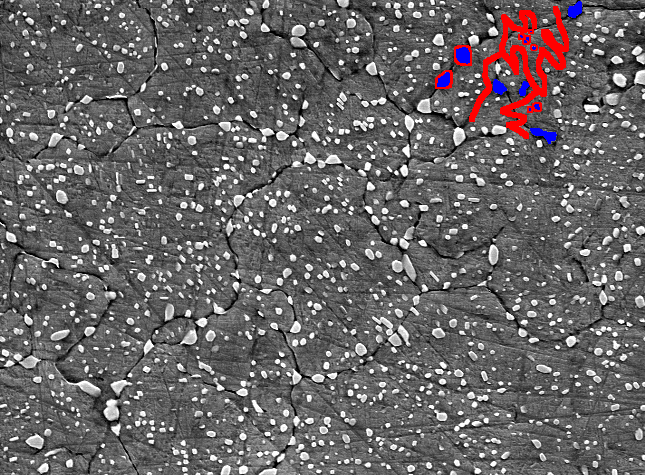

In [16]:
# load images
file_img = "./data_files/Spheroidite particles/image/970C-5M-Q-2.png"
file_scr = "./data_files/Spheroidite particles/scribble/970C-5M-Q-2.png"

img = cv2.imread(file_img)
scr = cv2.imread(file_scr)
scr = change_background(scr)

# show images
image_overlay(img, scr)

In [17]:
# image tensor
img_ = torch.from_numpy((img.transpose((2,0,1)).astype('float32') / 255.)[np.newaxis,:,:,:])
img_ = img_.cuda()

# get mask and correspondance
mask, corr = masking(scr)
n_label = len(np.unique(mask)) - 1

# index tensor
target_scr = torch.from_numpy(mask).long().cuda()
idx_sim = torch.from_numpy(np.where(mask == np.unique(mask)[-1])[0]).cuda()
idx_scr = torch.from_numpy(np.where(mask != np.unique(mask)[-1])[0]).cuda()

print("The number of class: {}".format(n_label))

The number of class: 2


## 3. Implement Weakly-Supervised Segmentation

In [18]:
# round of active learning
round_ = 0

In [19]:
# parameters
n_channel = n_label
n_conv = 3

In [20]:
# architecture
class Model(nn.Module):
    def __init__(self, input_dim):
        super(Model, self).__init__()
        
        model = [nn.Conv2d(input_dim, 64, kernel_size = 3, stride = 1, dilation = 1, padding = 1),
                 nn.ReLU(inplace = True),
                 nn.BatchNorm2d(64)]
        
        for _ in range(n_conv):
            model += [nn.Conv2d(64, 64, kernel_size = 3, stride = 1, dilation = 1, padding = 1),
                      nn.ReLU(inplace = True),
                      nn.BatchNorm2d(64)]
        
        model += [nn.Conv2d(64, n_channel, kernel_size = 1, stride = 1, padding = 0),
                  nn.BatchNorm2d(n_channel)]
        
        self.model = nn.Sequential(*model)
        
    def forward(self, x):
        return self.model(x)

In [2]:
# round of active learning
round_ += 1

# build a network
model = Model(img_.size(1))
model.cuda()

# define loss functions
criterion_sim = torch.nn.CrossEntropyLoss()
criterion_scr = torch.nn.CrossEntropyLoss()
criterion_con_y = torch.nn.L1Loss(size_average = True)
criterion_con_z = torch.nn.L1Loss(size_average = True)

# learning rate
n_iter = 20000
lr = 0.05

# define optimizer
optimizer = optim.Adam(model.parameters(), lr = lr)
lr_scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda = LambdaLR(n_iter, int(n_iter / 2)).step)

## 4. Optimize

In [1]:
# print option
n_prt = 50

# loss function weight
lambda_sim = 1
lambda_con = 0.
lambda_scr = 1

# mode
model.train()
criteria = 1e10

# optimize
for i in range(n_iter):
    
    # zero gradient
    optimizer.zero_grad()
    
    # forward
    pred = model(img_)[0]
    pred = pred.permute(1,2,0)
    
    pred_con_y = pred[1:,:,:] - pred[0:-1,:,:]
    pred_con_z = pred[:,1:,:] - pred[:,0:-1,:]
    target_con_y = torch.zeros(img_.size(2) - 1, img_.size(3), n_channel).cuda()
    target_con_z = torch.zeros(img_.size(2), img_.size(3) - 1, n_channel).cuda()
    
    pred = pred.contiguous().view(-1, n_channel)
    _, target_sim = torch.max(pred, 1)
    
    # loss
    loss_sim = criterion_sim(pred[idx_sim], target_sim[idx_sim])
    loss_scr = criterion_scr(pred[idx_scr], target_scr[idx_scr])
    loss_con = criterion_con_y(pred_con_y, target_con_y) + criterion_con_z(pred_con_z, target_con_z)
    loss = lambda_sim * loss_sim + lambda_scr * loss_scr + lambda_con * loss_con
    
    # update gradient
    loss.backward()
    optimizer.step()
    
    # print and save
    if i % n_prt == 0:
        print(i, '/', n_iter, '|', ' label num :', len(np.unique(target_sim.cpu().numpy())), ' | loss :', loss.item())
        
        if loss.item() < criteria:
            model_dir = './ckpt_files/' + file_img.split('/')[-1].split('.')[0] + '/'
            save_model(model, model_dir)
            
            criteria = loss.item()
    
    # step learning rate
    lr_scheduler.step()

## 5. Evaluation

In [22]:
# load model
model_dir = './ckpt_files/' + file_img.split('/')[-1].split('.')[0] + '/'
load_model(model, model_dir)

# load test image
img = cv2.imread("./data_files/Spheroidite particles/image/970C-5M-Q-2.png")
img_ = torch.from_numpy((img.transpose((2,0,1)).astype('float32') / 255.)[np.newaxis,:,:,:])
img_ = img_.cuda()

# forward propagation
model.eval()
pred = model(img_)[0]
pred = pred.permute(1,2,0)
prob_map = F.softmax(pred, dim = 2)
_, pred_max = torch.max(pred, 2)
pred_max = pred_max.cpu().numpy()

# segmentation map
# colors = np.random.randint(255, size = (n_channel, 3))
# seg_map = np.array([colors[c % n_channel] for c in pred_max])
seg_map = np.array([corr[c] for c in pred_max])
seg_map = seg_map.reshape(img_.size(2), img_.size(3), 3).astype(np.uint8)

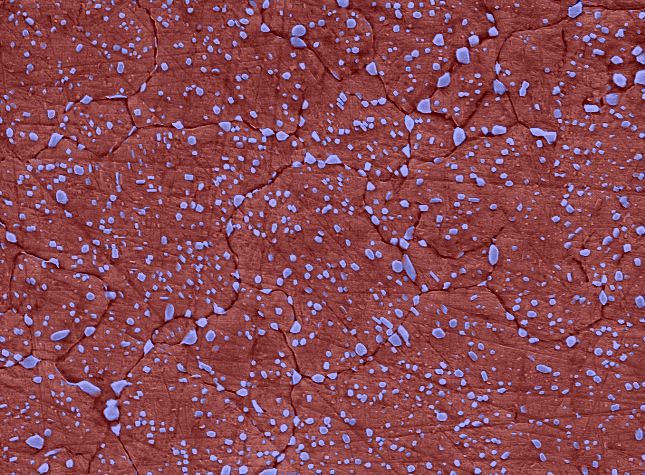

In [29]:
# save overlay result
result_dir = './result_files/' + file_img.split('/')[-1].split('.')[0]
make_dir(result_dir)

overlay_pil = image_blend(img, seg_map, 0.3)
# save_img(overlay_pil, result_dir + '/overlay_' + str(round_) + '.png')
overlay_pil

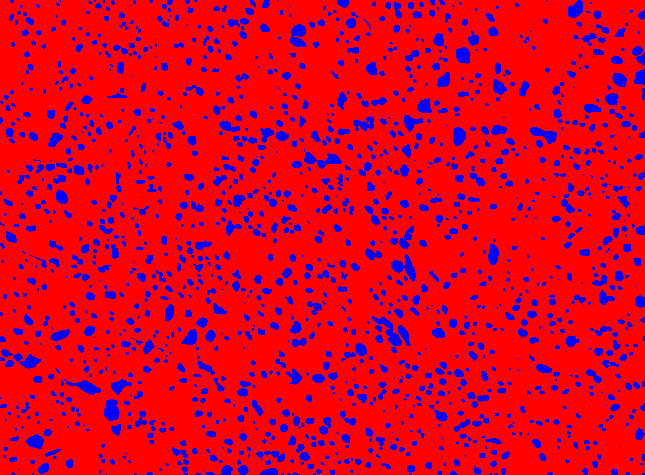

In [30]:
# save segmentation result
result_dir = './result_files/' + file_img.split('/')[-1].split('.')[0]
make_dir(result_dir)

seg_pil = Image.fromarray(seg_map)
# save_img(seg_pil, result_dir + '/segment_' + str(round_) + '.png')
seg_pil

## 6. Uncertainty Map

In [ ]:
# margin sampling
uc_map = (margin_sampling(prob_map).detach().cpu().numpy() * 255).astype('uint8')
uc_map_red = to_red(uc_map)

In [ ]:
# save uncertainty result
result_dir = './result_files/' + file_img.split('/')[-1].split('.')[0]
make_dir(result_dir)

uc_pil = Image.fromarray(uc_map_red)
# save_img(uc_pil, result_dir + '/ucmap_' + str(round_) + '.png')
image_blend(img, uc_map_red, 0.8)